# Importo y defino

In [1]:
"""Extract weighted energy spectra from multiple OpenMC surface_source.h5
files and consolidate them into a single XML, sharing a common binning.
"""

from __future__ import annotations
import os
from pathlib import Path
from typing import Union, List, Tuple

import numpy as np
import xml.etree.ElementTree as ET

import kdsource.surfsource as kds

import matplotlib.pyplot as plt






def extract_spectra(
    surf_paths: List[str],
    n_bins: int = 100,
    edges: Union[List[float], np.ndarray] = None,
    scale: str = "linear",
    xml_out: Union[str, Path] = "espectros.xml",
    region = None
) -> Path:
    """
    Build a single XML containing one shared bin‐edge vector and, for each
    surface_source file, its weighted-count histogram.

    Parameters
    ----------
    surf_paths
        List of paths to surface_source files.
    n_bins
        Number of bins to use.
    scale
        "linear" ⇒ equal‐width in ln(E0/E); "log" ⇒ logarithmic spacing.
    xml_out
        Path to write the XML (overwritten if exists).

    Returns
    -------
    Path
        The XML file generated.
    """
    # --- validate
    if scale not in {"linear", "log"}:
        raise ValueError("`scale` must be 'linear' or 'log'.")

    xml_out = Path(xml_out).expanduser().resolve()
    xml_out.parent.mkdir(parents=True, exist_ok=True)

    if edges is None:
        # --- PASS 1: find global min/max of letargy
        global_min = np.inf
        global_max = -np.inf
        for fp in surf_paths:
            ssf = kds.SurfaceSourceFile(fp, domain={"w": [0, 2]})
            df = ssf.get_pandas_dataframe()
            letargy = df["ln(E0/E)"].to_numpy(dtype=np.float64, copy=False)
            global_min = min(global_min, letargy.min())
            global_max = max(global_max, letargy.max())

        # --- build common edges
        if scale == "linear":
            edges = np.linspace(global_min, global_max, n_bins + 1, dtype=np.float64)
        else:
            edges = np.logspace(global_min, global_max, n_bins + 1, dtype=np.float64)

    # --- XML root with single BinEdges
    root = ET.Element("Spectra", bins=str(n_bins), scale=scale)
    ET.SubElement(root, "BinEdges").text = _array_to_csv(edges)

    # --- PASS 2: histogram each file
    for fp in surf_paths:
        if region is None:
            ssf = kds.SurfaceSourceFile(fp, domain={"w": [0, 2]})
            df = ssf.get_pandas_dataframe() 
            letargy = df["ln(E0/E)"].to_numpy(dtype=np.float64, copy=False)
            weights = df["wgt"].to_numpy(dtype=np.float64, copy=False)
        if region == "agua":
            ssf1 = kds.SurfaceSourceFile(fp, domain={"w": [0, 2],"x":[-10,-1.5]})
            df1 = ssf1.get_pandas_dataframe()
            letargy1 = df1["ln(E0/E)"].to_numpy(dtype=np.float64, copy=False)
            weights1 = df1["wgt"].to_numpy(dtype=np.float64, copy=False)
            del ssf1, df1

            ssf2 = kds.SurfaceSourceFile(fp, domain={"w": [0, 2],"x":[1.5,10]})
            df2 = ssf2.get_pandas_dataframe()
            letargy2 = df2["ln(E0/E)"].to_numpy(dtype=np.float64, copy=False)
            weights2 = df2["wgt"].to_numpy(dtype=np.float64, copy=False)
            del ssf2, df2

            ssf3 = kds.SurfaceSourceFile(fp, domain={"w": [0, 2],"x":[-1.5,1.5],"y":[1.5,10]})
            df3 = ssf3.get_pandas_dataframe()
            letargy3 = df3["ln(E0/E)"].to_numpy(dtype=np.float64, copy=False)
            weights3 = df3["wgt"].to_numpy(dtype=np.float64, copy=False)
            del ssf3, df3

            ssf4 = kds.SurfaceSourceFile(fp, domain={"w": [0, 2],"x":[-1.5,1.5],"y":[-10,-1.5]})
            df4 = ssf4.get_pandas_dataframe()
            letargy4 = df4["ln(E0/E)"].to_numpy(dtype=np.float64, copy=False)
            weights4 = df4["wgt"].to_numpy(dtype=np.float64, copy=False)
            del ssf4, df4

            letargy = np.concatenate((letargy1, letargy2, letargy3, letargy4))
            weights = np.concatenate((weights1, weights2, weights3, weights4))
        if region == "vacio":
            ssf = kds.SurfaceSourceFile(fp, domain={"w": [0, 2], "x": [-1.5, 1.5], "y": [-1.5, 1.5]})
            df = ssf.get_pandas_dataframe() 
            letargy = df["ln(E0/E)"].to_numpy(dtype=np.float64, copy=False)
            weights = df["wgt"].to_numpy(dtype=np.float64, copy=False)
                
        counts, _ = np.histogram(letargy, bins=edges, weights=weights)
        counts2, _ = np.histogram(letargy, bins=edges, weights=weights**2)

        hist_el = ET.SubElement(root, "Histogram", file=Path(fp).name)
        ET.SubElement(hist_el, "Counts").text = _array_to_csv(counts)
        ET.SubElement(hist_el, "CountsSquared").text = _array_to_csv(counts2)

    # --- pretty‐print & write
    _indent_xml(root)
    tree = ET.ElementTree(root)
    tree.write(xml_out, encoding="utf-8", xml_declaration=True)

    return xml_out

def _array_to_csv(arr: np.ndarray) -> str:
    """Convert a NumPy array to a compact comma-separated string."""
    return ",".join(f"{v:.6e}" for v in arr)

def _indent_xml(elem: ET.Element, level: int = 0) -> None:
    """Recursively indent an XML *Element* for pretty printing."""
    indent = "  " * level
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = "\n" + indent + "  "
        for child in elem:
            _indent_xml(child, level + 1)
        if not child.tail or not child.tail.strip():
            child.tail = "\n" + indent
    if level and (not elem.tail or not elem.tail.strip()):
        elem.tail = "\n" + indent




def load_merged_spectrum(xml_path: Union[str, Path]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Carga un XML con la estructura de <Spectra> y devuelve los vectores de
    bin-edges y de cuentas totales (suma de todos los <Counts>).

    Parameters
    ----------
    xml_path : str or Path
        Camino al archivo XML producido por `extract_spectra`.

    Returns
    -------
    edges : np.ndarray, shape (n_bins+1,)
        Vector de los valores de los límites de bin.
    total_counts : np.ndarray, shape (n_bins,)
        Vector de cuentas, suma de todos los histogramas.
    total_counts2 : np.ndarray, shape (n_bins,)
            Vector de cuentas al cuadrado, suma de todos los histogramas.
    
    Raises
    ------
    ValueError
        Si falta el nodo <BinEdges> o algún <Counts>, o sus longitudes no coinciden.
    """
    # Garantizar objeto Path
    xml_path = Path(xml_path)
    # Parsear XML
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # 1) Extraer y parsear los bin edges
    edges_text = root.findtext("BinEdges")
    if edges_text is None:
        raise ValueError("No se encontró el elemento <BinEdges> en el XML.")
    # Convierte la cadena "v1,v2,..." en float array
    edges = np.fromstring(edges_text, sep=",")

    # Número de bins = len(edges) - 1
    n_counts = edges.size - 1
    # Inicializar el acumulador de counts
    total_counts = np.zeros(n_counts, dtype=float)
    total_counts2 = np.zeros(n_counts, dtype=float)

    # 2) Recorrer cada <Histogram> y sumar sus <Counts>
    for hist_el in root.findall("Histogram"):
        counts_text = hist_el.findtext("Counts")
        if counts_text is None:
            fname = hist_el.get("file", "<desconocido>")
            raise ValueError(f"No se encontró <Counts> en el histograma '{fname}'.")
        counts = np.fromstring(counts_text, sep=",")
        # Validar consistencia de longitudes
        if counts.size != n_counts:
            fname = hist_el.get("file", "<desconocido>")
            raise ValueError(
                f"El histograma '{fname}' tiene {counts.size} bins, "
                f"pero se esperaban {n_counts}."
            )
        total_counts += counts
        # Extraer y sumar los CountsSquared
        counts2_text = hist_el.findtext("CountsSquared")
        if counts2_text is None:
            fname = hist_el.get("file", "<desconocido>")
            raise ValueError(f"No se encontró <CountsSquared> en el histograma '{fname}'.")
        counts2 = np.fromstring(counts2_text, sep=",")
        # Validar consistencia de longitudes
        if counts2.size != n_counts:
            fname = hist_el.get("file", "<desconocido>")
            raise ValueError(
                f"El histograma '{fname}' tiene {counts2.size} bins, "
                f"pero se esperaban {n_counts}."
            )
        total_counts2 += counts2

    return edges, total_counts, total_counts2


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def plot_spectrum_comparison(
    z_orig: np.ndarray,
    flux_orig: np.ndarray,
    z_sint: np.ndarray,
    flux_sint: np.ndarray,
    factor: float = 1.0,
    save: bool = True,
    filename: str = "comparacion_espectros.png"
) -> None:
    """
    Compara gráficamente el espectro entre las versiones original y remuestreada,
    incluyendo el error relativo interpolado sobre el eje z del remuestreado.

    Parámetros
    ----------
    z_orig : ndarray
        Vector de z del espectro original.
    flux_orig : ndarray
        Vector de intensidades del espectro original.
    z_sint : ndarray
        Vector de z del espectro remuestreado.
    flux_sint : ndarray
        Vector de intensidades del espectro remuestreado.
    factor : float, opcional
        Factor de escala para ajustar el flujo sintético antes de la comparación.
    save : bool, opcional
        Si es True, guarda la figura como un archivo PNG.
    filename : str, opcional
        Nombre del archivo PNG a guardar si save es True.
    """

    def compute_relative_error(z_orig, flux_orig, z_sint, flux_sint, factor):
        interp_orig = np.interp(z_sint, z_orig, flux_orig)
        scaled_sint = flux_sint * factor

        mask_nonzero = interp_orig != 0
        err_rel = np.full_like(interp_orig, fill_value=np.nan)
        err_rel[mask_nonzero] = 100 * (interp_orig[mask_nonzero] - scaled_sint[mask_nonzero]) / interp_orig[mask_nonzero]
        err_rel[~mask_nonzero] = np.inf
        return err_rel

    err_rel = compute_relative_error(z_orig, flux_orig, z_sint, flux_sint, factor)

    fig = plt.figure(figsize=(7, 6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])

    ax0.plot(z_orig, flux_orig, label="Original", color="blue", linestyle="--", marker="o")
    ax0.plot(z_sint, flux_sint * factor, label="Remuestreado", color="red", linestyle="-", marker="x")
    ax0.set_ylabel(r"$\frac{Espectro }{S_0}$",fontsize=12)
    ax0.set_yscale("log")
    ax0.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax0.legend()
    # ax0.set_title("Comparación del espectro en la superficie")

    ax1.plot(z_sint, err_rel, color="black")
    ax1.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax1.set_ylabel("Error relativo [%]",fontsize=12)
    ax1.set_xlabel("Letargía", fontsize=12)
    ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Ajustar límites del eje y para error relativo entre -100 y 100 (o menor si corresponde)
    finite_err = err_rel[np.isfinite(err_rel)]
    if finite_err.size > 0:
        y_min, y_max = finite_err.min(), finite_err.max()
        ax1.set_ylim(max(y_min, -100), min(y_max, 100))
    else:
        ax1.set_ylim(-100, 100)

    plt.tight_layout()

    if save:
        plt.savefig(filename, bbox_inches="tight", dpi=600)
    plt.show()



# Corrida 16

## Extraigo

In [ ]:
surface_sources = []
# for i in [100]:
for i in [100,200,300,400,500,700,1000,1200,1500,2500,3500,5000,7000,8000,9000,11000,14000]:
    surface_sources.append(f"/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida16/surface_source_{i}.h5")

# xml_path = extract_spectra(
#     surf_paths=surface_sources,
#     n_bins=75,
#     scale="linear",
#     xml_out="espectros_corrida16.xml",
# )
# print(f"XML guardado en {xml_path}")

xml_path = extract_spectra(
    surf_paths=surface_sources,
    n_bins=75,
    scale="linear",
    xml_out="espectros_corrida_agua_16.xml",
    region="agua"
)

xml_path = extract_spectra(
    surf_paths=surface_sources,
    n_bins=75,
    scale="linear",
    xml_out="espectros_corrida_vacio_16.xml",
    region="vacio"
)

Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida16/surface_source_100.h5: 26414
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida16/surface_source_200.h5: 2458549
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida16/surface_source_300.h5: 5002746
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida16/surface_source_400.h5: 1573445
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida16/surface_source_500.h5: 1030887
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida16/surface_source_700.h5: 3952673
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particle

## Total

[ 2.995732  3.343891  3.692051  4.04021   4.388369  4.736528  5.084687
  5.432847  5.781006  6.129165  6.477324  6.825483  7.173642  7.521802
  7.869961  8.21812   8.566279  8.914438  9.262597  9.610757  9.958916
 10.30707  10.65523  11.00339  11.35155  11.69971  12.04787  12.39603
 12.74419  13.09235  13.44051  13.78867  14.13683  14.48499  14.83314
 15.1813   15.52946  15.87762  16.22578  16.57394  16.9221   17.27026
 17.61842  17.96658  18.31474  18.6629   19.01105  19.35921  19.70737
 20.05553  20.40369  20.75185  21.10001  21.44817  21.79633  22.14449
 22.49265  22.84081  23.18896  23.53712  23.88528  24.23344  24.5816
 24.92976  25.27792  25.62608  25.97424  26.3224   26.67056  27.01872
 27.36687  27.71503  28.06319  28.41135  28.75951  29.10767 ]
0.013942884846788144


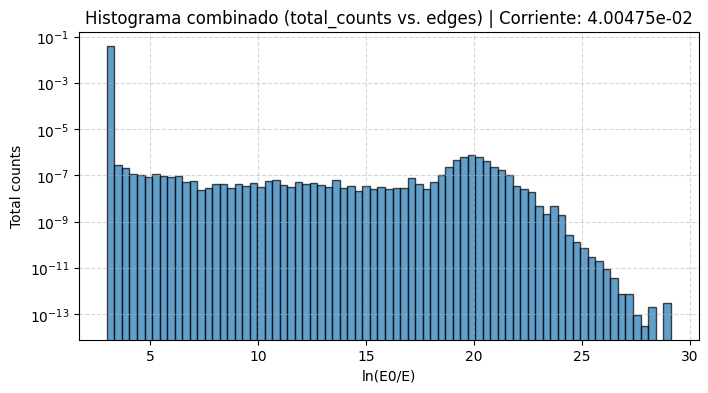

In [3]:
edges_original, total_counts = load_merged_spectrum("espectros_corrida16.xml")
print(edges_original)

total_simulado = 14000 * 5000  # Total de partículas simuladas
corriente = total_counts.sum() / total_simulado  # Corriente total


# Calcular el centro y ancho de cada bin
bin_centers_original = (edges_original[:-1] + edges_original[1:]) / 2
bin_widths = np.diff(edges_original)

# Normalizar el espectro para que el área bajo la curva sea 1
# area = np.sum(total_counts * bin_widths)
area = total_simulado
# total_counts_original = total_counts / area
total_counts_original = total_counts / total_simulado

print(np.sum(total_counts_original * bin_widths))

plt.figure(figsize=(8, 4))
plt.bar(bin_centers_original, total_counts_original,
    width=bin_widths,
    align='center',
    edgecolor='k',
    alpha=0.7)
plt.xlabel('ln(E0/E)')
plt.ylabel('Total counts')
plt.title('Histograma combinado (total_counts vs. edges) | Corriente: {:.5e}'.format(corriente))
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale('log')  # Escala logarítmica en el eje y
plt.show()

## Agua

Corriente total: 2.7369597010523107e-06
Error en la corriente total: 7.142452466431861e-08
9.52898022364988e-07


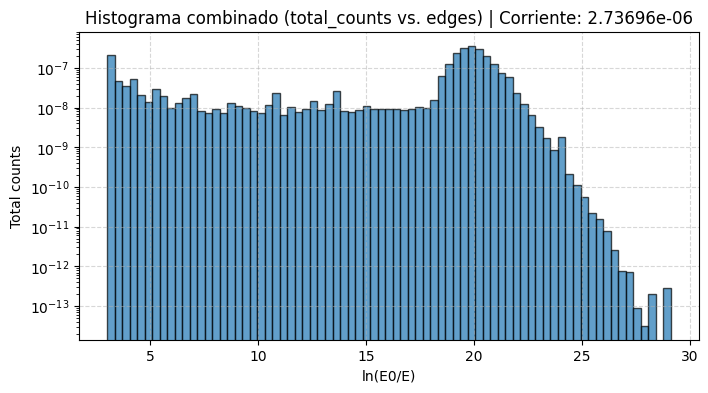

In [2]:
edges_original_agua, total_counts, total_counts2 = load_merged_spectrum("espectros_corrida_agua_16.xml")
# print(edges_original)

total_simulado = 14000 * 5000  # Total de partículas simuladas
corriente = total_counts.sum() / total_simulado  # Corriente total
error_corriente = np.sqrt(total_counts2.sum()) / total_simulado  # Error en la corriente total
print("Corriente total:", corriente)
print("Error en la corriente total:", error_corriente)


# Calcular el centro y ancho de cada bin
bin_centers_original_agua = (edges_original_agua[:-1] + edges_original_agua[1:]) / 2
bin_widths = np.diff(edges_original_agua)

# Normalizar el espectro para que el área bajo la curva sea 1
# area = np.sum(total_counts * bin_widths)
area = total_simulado
# total_counts_original = total_counts / area
total_counts_original_agua = total_counts / total_simulado

print(np.sum(total_counts_original_agua * bin_widths))

plt.figure(figsize=(8, 4))
plt.bar(bin_centers_original_agua, total_counts_original_agua,
    width=bin_widths,
    align='center',
    edgecolor='k',
    alpha=0.7)
plt.xlabel('ln(E0/E)')
plt.ylabel('Total counts')
plt.title('Histograma combinado (total_counts vs. edges) | Corriente: {:.5e}'.format(corriente))
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale('log')  # Escala logarítmica en el eje y
plt.show()

## Vacio

Corriente total: 0.0400447271640624
Error en la corriente total: 2.3917276579769742e-05
0.013941932166251744


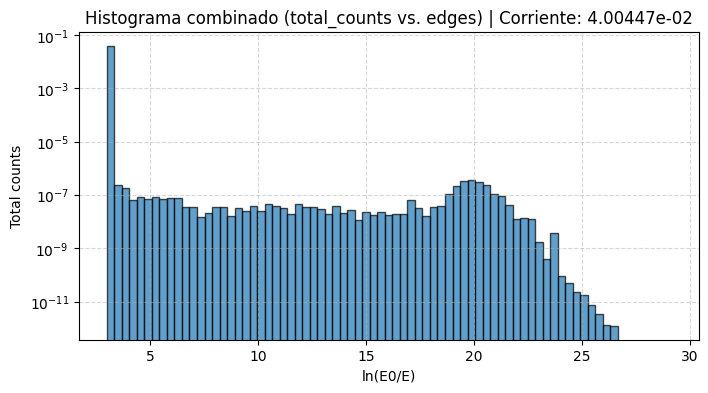

In [3]:
edges_original_vacio, total_counts, total_counts2 = load_merged_spectrum("espectros_corrida_vacio_16.xml")
# print(edges_original)

total_simulado = 14000 * 5000  # Total de partículas simuladas
corriente = total_counts.sum() / total_simulado  # Corriente total
error_corriente = np.sqrt(total_counts2.sum()) / total_simulado  # Error en la corriente total
print("Corriente total:", corriente)
print("Error en la corriente total:", error_corriente)

# Calcular el centro y ancho de cada bin
bin_centers_original_vacio = (edges_original_vacio[:-1] + edges_original_vacio[1:]) / 2
bin_widths = np.diff(edges_original_vacio)

# Normalizar el espectro para que el área bajo la curva sea 1
# area = np.sum(total_counts * bin_widths)
area = total_simulado
# total_counts_original = total_counts / area
total_counts_original_vacio = total_counts / total_simulado

print(np.sum(total_counts_original_vacio * bin_widths))

plt.figure(figsize=(8, 4))
plt.bar(bin_centers_original_vacio, total_counts_original_vacio,
    width=bin_widths,
    align='center',
    edgecolor='k',
    alpha=0.7)
plt.xlabel('ln(E0/E)')
plt.ylabel('Total counts')
plt.title('Histograma combinado (total_counts vs. edges) | Corriente: {:.5e}'.format(corriente))
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale('log')  # Escala logarítmica en el eje y
plt.show()

# Corrida 17

## Extraigo

In [4]:
surface_sources = []
for i in [500,750,1250,1750,2000,3000,4000,5100,6200,7500,9000,9500,10500,11500,12500]:
    surface_sources.append(f"/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida17/surface_source_{i}.h5")

# xml_path = extract_spectra(
#     surf_paths=surface_sources,
#     n_bins=100,
#     edges=edges_original,  # Usar los mismos bordes que el espectro anterior
#     scale="linear",
#     xml_out="espectros_corrida17.xml",
# )
# print(f"XML guardado en {xml_path}")

xml_path = extract_spectra(
    surf_paths=surface_sources,
    n_bins=75,
    edges=edges_original_agua,
    scale="linear",
    xml_out="espectros_corrida_agua_17.xml",
    region="agua"
)

xml_path = extract_spectra(
    surf_paths=surface_sources,
    n_bins=75,
    edges=edges_original_vacio,
    scale="linear",
    xml_out="espectros_corrida_vacio_17.xml",
    region="vacio"
)

Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida17/surface_source_500.h5: 12814932
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida17/surface_source_500.h5: 12814932
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida17/surface_source_500.h5: 12814932
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida17/surface_source_500.h5: 12814932
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida17/surface_source_750.h5: 3962379
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida17/surface_source_750.h5: 3962379
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of pa

## Total

In [5]:
edges, total_counts, total_counts2 = load_merged_spectrum("espectros_corrida17.xml")

total_simulado = 6200 * 5000  # Total de partículas simuladas
corriente = total_counts.sum() / total_simulado  * 9.17996691e-02# Corriente total
error_corriente = np.sqrt(total_counts2.sum()) / total_simulado  # Error en la corriente total
print("Corriente total:", corriente)
print("Error en la corriente total:", error_corriente)

# Calcular el centro y ancho de cada bin
bin_centers = (edges[:-1] + edges[1:]) / 2
bin_widths = np.diff(edges)

# Normalizar el espectro para que el área bajo la curva sea 1
# area = np.sum(total_counts * bin_widths)
area = total_simulado / 9.17996691e-02
total_counts = total_counts / area

plt.figure(figsize=(8, 4))
plt.bar(bin_centers, total_counts,
    width=bin_widths,
    align='center',
    edgecolor='k',
    alpha=0.7)
plt.xlabel('ln(E0/E)')
plt.ylabel('Total counts')
plt.title('Histograma combinado (total_counts vs. edges) | Corriente: {:.5e}'.format(corriente))
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale('log')  # Escala logarítmica en el eje y
plt.show()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x74ccbe072500>>
Traceback (most recent call last):
  File "/home/lucas/anaconda3/envs/proyecto_integrador/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


FileNotFoundError: [Errno 2] No such file or directory: 'espectros_corrida17.xml'

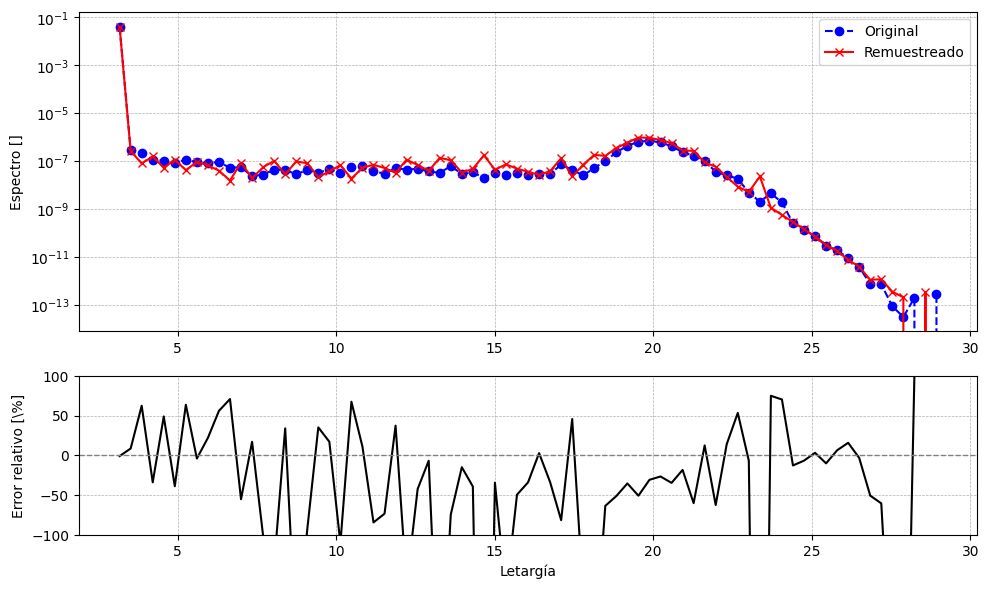

In [ ]:
# %matplotlib widget
plot_spectrum_comparison(
    z_orig=bin_centers_original,
    flux_orig=total_counts_original,
    z_sint=bin_centers,
    flux_sint=total_counts,
    factor=1.0,  # Ajusta este factor según sea necesario
    save=False,
    filename="comparacion_espectros.png"
)

## Agua

Corriente total: 2.609326801314914e-06
Error en la corriente total: 2.272784353902075e-07


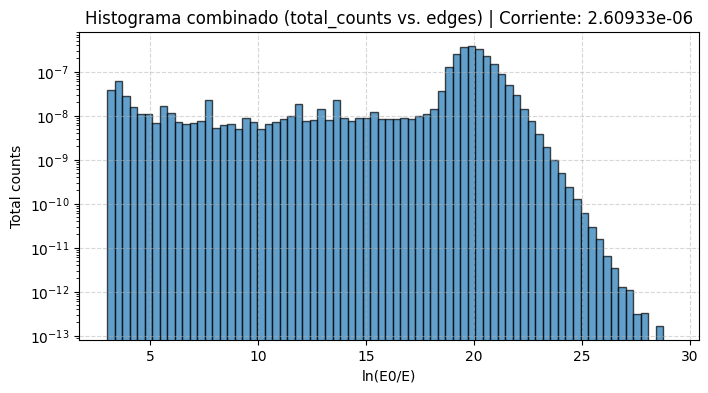

In [11]:
edges, total_counts, total_counts2 = load_merged_spectrum("espectros_corrida_agua_17.xml")

total_simulado = 12500 * 5000  # Total de partículas simuladas
corriente = total_counts.sum() / total_simulado  * 9.17996691e-02# Corriente total
error_corriente = np.sqrt(total_counts2.sum()) / total_simulado  # Error en la corriente total
print("Corriente total:", corriente)
print("Error en la corriente total:", error_corriente)

# Calcular el centro y ancho de cada bin
bin_centers = (edges[:-1] + edges[1:]) / 2
bin_widths = np.diff(edges)

# Normalizar el espectro para que el área bajo la curva sea 1
# area = np.sum(total_counts * bin_widths)
area = total_simulado / 9.17996691e-02
total_counts = total_counts / area

plt.figure(figsize=(8, 4))
plt.bar(bin_centers, total_counts,
    width=bin_widths,
    align='center',
    edgecolor='k',
    alpha=0.7)
plt.xlabel('ln(E0/E)')
plt.ylabel('Total counts')
plt.title('Histograma combinado (total_counts vs. edges) | Corriente: {:.5e}'.format(corriente))
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale('log')  # Escala logarítmica en el eje y
plt.show()

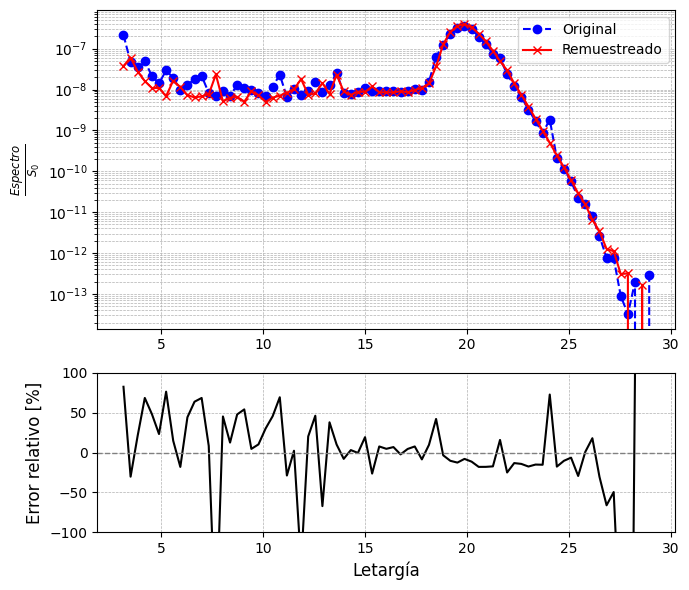

In [12]:
# %matplotlib widget
plot_spectrum_comparison(
    z_orig=bin_centers_original_agua,
    flux_orig=total_counts_original_agua,
    z_sint=bin_centers,
    flux_sint=total_counts,
    factor=1.0,  # Ajusta este factor según sea necesario
    save=False,
    filename="comparacion_espectros.png"
)

## Vacio

Corriente total: 0.04036999111942352
Error en la corriente total: 8.38808019795845e-05


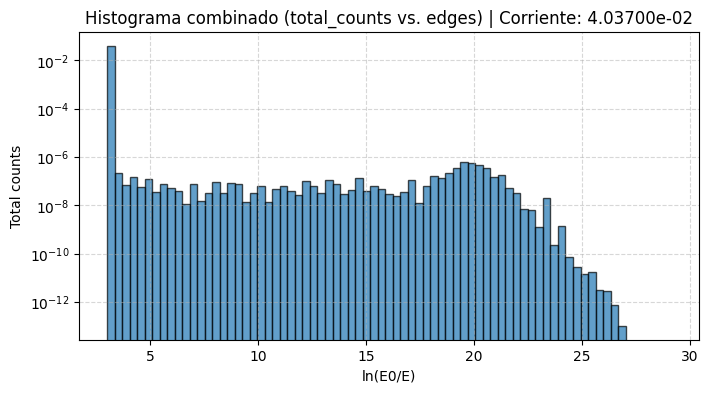

In [13]:
edges, total_counts, total_counts2  = load_merged_spectrum("espectros_corrida_vacio_17.xml")

total_simulado = 12500 * 5000  # Total de partículas simuladas
corriente = total_counts.sum() / total_simulado  * 9.17996691e-02# Corriente total
error_corriente = np.sqrt(total_counts2.sum()) / total_simulado  # Error en la corriente total
print("Corriente total:", corriente)
print("Error en la corriente total:", error_corriente)

# Calcular el centro y ancho de cada bin
bin_centers = (edges[:-1] + edges[1:]) / 2
bin_widths = np.diff(edges)

# Normalizar el espectro para que el área bajo la curva sea 1
# area = np.sum(total_counts * bin_widths)
area = total_simulado / 9.17996691e-02
total_counts = total_counts / area

plt.figure(figsize=(8, 4))
plt.bar(bin_centers, total_counts,
    width=bin_widths,
    align='center',
    edgecolor='k',
    alpha=0.7)
plt.xlabel('ln(E0/E)')
plt.ylabel('Total counts')
plt.title('Histograma combinado (total_counts vs. edges) | Corriente: {:.5e}'.format(corriente))
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale('log')  # Escala logarítmica en el eje y
plt.show()

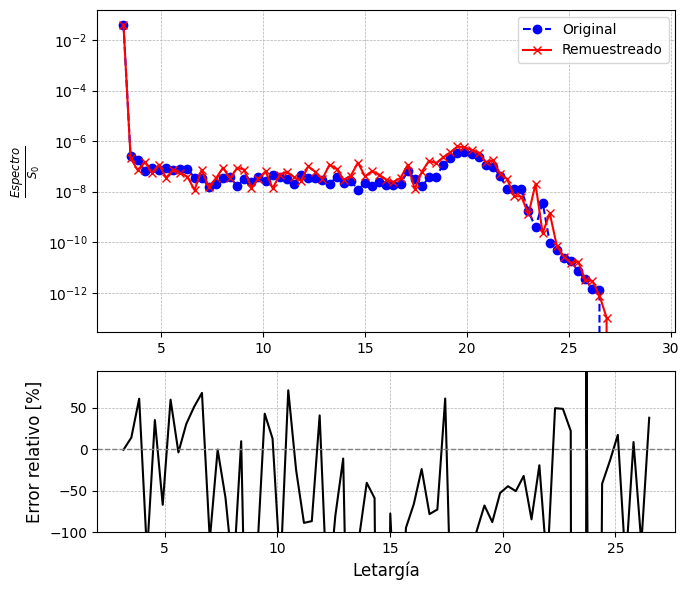

In [14]:
# %matplotlib widget
plot_spectrum_comparison(
    z_orig=bin_centers_original_vacio,
    flux_orig=total_counts_original_vacio,
    z_sint=bin_centers,
    flux_sint=total_counts,
    factor=1.0,  # Ajusta este factor según sea necesario
    save=False,
    filename="comparacion_espectros.png"
)

# Corrida 18

In [ ]:
surface_sources = []
for i in [500,1250,1500,1750,2750,3750,4500,5500,6500,7500]:
    surface_sources.append(f"/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida18/surface_source_{i}.h5")

xml_path = extract_spectra(
    surf_paths=surface_sources,
    n_bins=100,
    edges = edges_original,
    scale="linear",
    xml_out="espectros_corrida18.xml",
)
print(f"XML guardado en {xml_path}")

Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida18/surface_source_500.h5: 14733637
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida18/surface_source_1250.h5: 12720825
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida18/surface_source_1500.h5: 3277071
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida18/surface_source_1750.h5: 4504627
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida18/surface_source_2750.h5: 13577002
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida18/surface_source_3750.h5: 13455101
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number 

[ 2.995732  3.343891  3.692051  4.04021   4.388369  4.736528  5.084687
  5.432847  5.781006  6.129165  6.477324  6.825483  7.173642  7.521802
  7.869961  8.21812   8.566279  8.914438  9.262597  9.610757  9.958916
 10.30707  10.65523  11.00339  11.35155  11.69971  12.04787  12.39603
 12.74419  13.09235  13.44051  13.78867  14.13683  14.48499  14.83314
 15.1813   15.52946  15.87762  16.22578  16.57394  16.9221   17.27026
 17.61842  17.96658  18.31474  18.6629   19.01105  19.35921  19.70737
 20.05553  20.40369  20.75185  21.10001  21.44817  21.79633  22.14449
 22.49265  22.84081  23.18896  23.53712  23.88528  24.23344  24.5816
 24.92976  25.27792  25.62608  25.97424  26.3224   26.67056  27.01872
 27.36687  27.71503  28.06319  28.41135  28.75951  29.10767 ]
0.013722316886172897


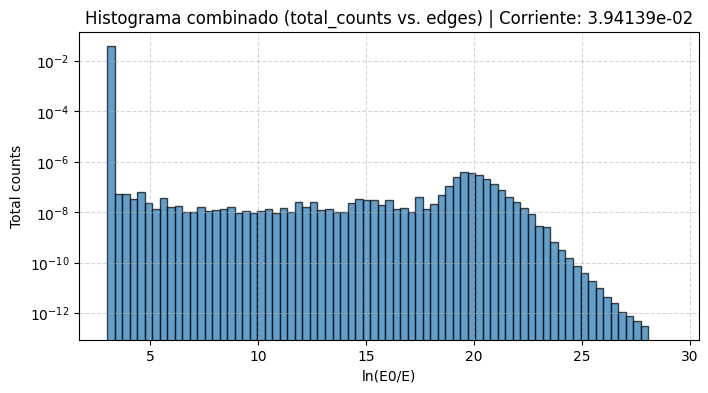

In [ ]:
edges, total_counts = load_merged_spectrum("espectros_corrida18.xml")
print(edges)

total_simulado = 7500 * 5000  # Total de partículas simuladas
corriente = total_counts.sum() / total_simulado  * 9.04915573e-02# Corriente total
# corriente = total_counts.sum() / total_simulado  * 9.17996691e-02 * 0.992# Corriente total


# Calcular el centro y ancho de cada bin
bin_centers = (edges[:-1] + edges[1:]) / 2
bin_widths = np.diff(edges)

# Normalizar el espectro para que el área bajo la curva sea 1
# area = np.sum(total_counts * bin_widths)
area = total_simulado / 9.04915573e-02
total_counts = total_counts / area

print(np.sum(total_counts * bin_widths))

plt.figure(figsize=(8, 4))
plt.bar(bin_centers, total_counts,
    width=bin_widths,
    align='center',
    edgecolor='k',
    alpha=0.7)
plt.xlabel('ln(E0/E)')
plt.ylabel('Total counts')
plt.title('Histograma combinado (total_counts vs. edges) | Corriente: {:.5e}'.format(corriente))
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale('log')  # Escala logarítmica en el eje y
plt.show()

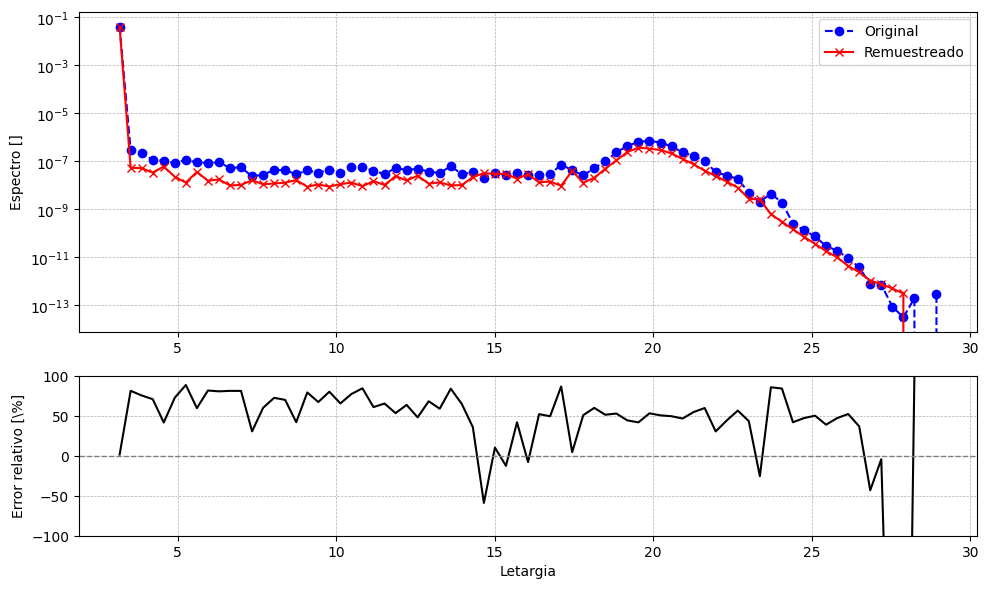

In [ ]:
# %matplotlib widget
plot_spectrum_comparison(
    z_orig=bin_centers_original,
    flux_orig=total_counts_original,
    z_sint=bin_centers,
    flux_sint=total_counts,
    factor=1.0,  # Ajusta este factor según sea necesario
    save=False,
    filename="comparacion_espectros.png"
)